In [1]:
"""
This file uses AI evolutionary algorithms sovle Sudoku puzzles
By Madelyn Redick
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import random


def get_structure(puzzle, structure, idx, sg_idx=0):
    """ returns a row, column, or subgrid at given index(es)

    Args:
        puzzle (numpy.ndarray): 9x9 puzzle
        structure (string): row, column, or subgrid
        idx (int): starting index of structure
        sg_idx (int): y index of subgrid, optional, default=0

    Returns:
        arr (numpy.ndarray): desired structure type at given index(es) of shape (9,)
    """
    if structure == "row":
        arr = puzzle[idx]
    elif structure == "column":
        arr = puzzle[:, idx]
    elif structure == "subgrid":
        sub_x, sub_y = get_subgrid_coordinates(idx, sg_idx)
        arr = np.array(list(puzzle[sub_x][sub_y:sub_y+3]) + list(puzzle[sub_x+1][sub_y:sub_y+3]) + list(puzzle[sub_x+2][sub_y:sub_y+3]))

    return arr

def count_zeros(puzzle): #TODO USE THIS ELSEWHERE
    return np.count_nonzero(puzzle == 0)

def get_subgrid_coordinates(x, y):
    """ get coordinates of top left cell of the subgrid containing cell (x, y)

    Args:
        x (int): row index, value between 0 and 8 inclusive
        y (int): column index, value between 0 and 8 inclusive

    Returns:
        sub_x (int): row index of top left cell of subgrid
        sub_y (int): column index of top left cell of subgrid
    """
    if x <= 2:
        sub_x = 0
    elif x <= 5:
        sub_x = 3
    else:
        sub_x = 6

    if y <= 2:
        sub_y = 0
    elif y <= 5:
        sub_y = 3
    else:
        sub_y = 6

    return sub_x, sub_y

def get_replacement_indexes(puzzle):
    """ get locations of non pre-filled cells

    Args:
        puzzle (numpy.ndarray): 9x9 puzzle

    Returns:
        replace (list): tuples of (row, column) indexes that are able to be filled
    """
    replace = []
    for i in range(9):
        for j in range(9):
            if puzzle[i][j] == 0:
                replace.append((i, j))
    return replace

def replace_structure(puzzle, arr, structure, idx, sg_idx=0):
    """ replaces a partially solved row/column/subgrid with its original

    Args:
        puzzle (numpy.ndarray): 9x9 puzzle
        sub_array (numpy.ndarray): row/column/subgrid of a puzzle
        structure (string): row, column, or subgrid
        idx (int): starting index of structure
        sg_idx (int): y index of subgrid, optional, default=0

    Returns:
        puzzle: partially filled 9x9 puzzle 
    """
    if structure == "row":
        puzzle[idx] = arr
    elif structure == "column":
        puzzle[:, idx] = arr
    elif structure == "subgrid":
        puzzle[idx][sg_idx:sg_idx+3] = arr[:3]
        puzzle[idx+1][sg_idx:sg_idx+3] = arr[3:6]
        puzzle[idx+2][sg_idx:sg_idx+3] = arr[6:]

    return puzzle

def get_remaining_values(arr):
    """ finds values not already present in the row/column/subgrid

    Args:
        arr (numpy.ndarray): represents row/column/subgrid of a puzzle

    Returns:
        rem_vals (numpy.ndarray): values not already present in the row/column/subgrid
    """
    rem_vals = [x+1 for x in range(9)]
    for v in arr:
        if v != 0 and v in rem_vals:
            rem_vals.remove(v)

    return np.array(rem_vals)

def get_valid_rep_values(puzzle, x, y, structure):
    """ find values not in a cell's row, column, and subgrid

    Args:
        puzzle (numpy.ndarray): 9x9 puzzle
        x (int): row index, value between 0 and 8 inclusive
        y (int): column index, value between 0 and 8 inclusive
        structure (string): row, column, or subgrid

    Returns:
        valid_values (list): integers that can be placed in (x, y) without violating puzzle constraints
    """
    # get corresponding row/column/subgrid arr
    if structure == "subgrid":
        arr = get_structure(puzzle, "subgrid", x, y)
        corr_arr_1 = get_structure(puzzle, "row", x)
        corr_arr_2 = get_structure(puzzle, "column", y)
    else:
        corr_arr_1 = get_structure(puzzle, "subgrid", x, y)
        if structure == "row":
            arr = get_structure(puzzle, "row", x)
            corr_arr_2 = get_structure(puzzle, "column", y)
        else:
            arr = get_structure(puzzle, "column", y)
            corr_arr_2 = get_structure(puzzle, "row", x)

    # get remaining values in structure
    struct_rem_vals = get_remaining_values(arr)
    
    # get valid values to replace
    valid_values = []
    for value in struct_rem_vals:
        if value not in corr_arr_1 and value not in corr_arr_2:
            valid_values.append(value)

    return valid_values #TODO USE THIS IN strat_fill_remaining_vals

def get_accuracy(unsolved, solved, generated_sol, percentage=True):
    """ calculates number of correctly placed values out of number of non pre-filled values

    Args:
        unsolved (numpy.ndarray): 9x9 unsolved puzzle
        solved (numpy.ndarray): 9x9 solved puzzle
        generated_sol (numpy.ndarray): 9x9 generated solution of unsolved puzzle
        percentage (bool, optional): True if you want the ratio returned, False if 
            you want the full breakdown dictoinary, defaults to True

    Returns:
        totals["correct"]/len(to_fill) (float): if percentage==True, ratio of correctly placed values to all replaceable cells
        totals (dictionary): if percentage==False, frequencies of correctly placed, incorrectly placed, and empty cells
    """

    # get indexes of values to be filled
    to_fill = get_replacement_indexes(unsolved)
    
    totals = {"correct":0, "zero":0, "incorrect":0} 
    for loc in to_fill:
        if generated_sol[loc[0]][loc[1]] == solved[loc[0]][loc[1]]:
            totals["correct"] += 1
        elif generated_sol[loc[0]][loc[1]] == 0:
            totals["zero"] += 1
        else:
            totals["incorrect"] += 1

    if percentage:
        # of all values needed to be filled, how many were correct
        return totals["correct"]/len(to_fill)
    return totals

def compare_parameters(to_solve, solved, population_sizes, generations):
    """ produces a dictionary containing information to plot results of genetic algorithm with different parameters
    TODO IS THIS NEEDED
    Args:
        to_solve (numpy.ndarray): 9x9 unsolved puzzle
        solved (numpy.ndarray): 9x9 solved puzzle
        population_sizes (list): integers, population sizes 
        generations (list): integers, numbers of generations

    Returns:
        results (dictionary): information to plot results of genetic algorithm with different parameters
    """
    results = {}
    for evolution in range(len(population_sizes)):

        # get population size and number of generations
        pop_size = population_sizes[evolution]
        gen_size = generations[evolution]

        # run genetic algorithm
        sol, fitness_score, time, zeros, gens = genetic_algorithm(to_solve, solved, pop_size, gen_size)

        # calculate accuracy
        accuracy = get_accuracy(to_solve, solved, sol)

        # consolidate results
        results[evolution] = {"solution":sol, "fitness_score":fitness_score, "accuracy":accuracy, "pop_size":pop_size, "gen_size":gen_size, "seconds":time, "zeros":zeros, "gens":gens}

    return results

def plot_compare_parameters(results):
    #TODO IS THIS NEEDED
    # Extract everything with their keys
    evolution_ids = list(results.keys())
    fitness_scores = [results[k]["fitness_score"] for k in evolution_ids]
    accuracies = [results[k]["accuracy"] for k in evolution_ids]
    pop_sizes = [results[k]["pop_size"] for k in evolution_ids]
    gen_sizes = [results[k]["gen_size"] for k in evolution_ids]
    times = [results[k]["seconds"] for k in evolution_ids]

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter 1: Accuracy vs Fitness Score
    axs[0].scatter(fitness_scores, accuracies, c='lightblue', marker='o')
    for i, k in enumerate(evolution_ids):
        axs[0].annotate(str(k), (fitness_scores[i], accuracies[i]), fontsize=8, alpha=0.7)
    axs[0].set_xlabel("Fitness Score")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy vs Fitness Score")
    axs[0].grid(True)

    # Scatter 2: Population Size vs Generation Size
    axs[1].scatter(pop_sizes, gen_sizes, c='orange', marker='s')
    for i, k in enumerate(evolution_ids):
        axs[1].annotate(str(k), (pop_sizes[i], gen_sizes[i], times[i]), fontsize=8, alpha=0.7)
    axs[1].set_xlabel("Population Size")
    axs[1].set_ylabel("Generation Size")
    axs[1].set_title("Population vs Generation")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig("acc_fit_vs_pop_gen.png")

def difficulty_level(puzzle):
    """ returns difficulty level based on number of initial zeros

    Args:
        puzzle (numpy.ndarray): 9x9 unsolved puzzle
    
    Returns:
        difficulty (str): easy, medium, or hard
    """
    if count_zeros(puzzle) < 30:
        return "Easy"
    elif count_zeros(puzzle) < 42:
        return "Medium"
    else:
        return "Hard"

def compare_puzzles(indexes, all_unsolved, all_solved, population_size, generations, mutations, hills):
    """ produces a dictionary containing information to plot results of genetic algorithm with different parameters/puzzles

    Args:
        indexes (list): integers representing indexes of desired puzzles
        all_unsolved (pandas.DataFrame): all unsolved puzzles
        all_solved (pandas.DataFrame): all solved puzzles
        population_size (list): integers, population sizes 
        generations (list): integers, numbers of generations  
        mutations (list): booleans, represent if genetic algorithm will contain mutations
        hills (list): booleans, represent if genetic algorithm will contain hill climbing

    Returns:
        results (dictionary): information to plot results of genetic algorithm with different parameters/puzzles
    """
    results = {}
    pop_gen_idx = 0
    for idx in range(len(indexes)):
        to_solve = all_unsolved[indexes[idx]]
        solved = all_solved[indexes[idx]]
        sol, fitness_score, time, zeros, gens = genetic_algorithm(to_solve, solved, population_size[pop_gen_idx], generations[pop_gen_idx], mutate=mutations[pop_gen_idx], hill_climbing=hills[pop_gen_idx])
        accuracy = get_accuracy(to_solve, solved, sol)
        results[idx] = {"puzzle_id":indexes[idx], "gen_solution":sol, "fitness_score":fitness_score, "accuracy":accuracy, "pop_size":population_size[pop_gen_idx], 
                        "gen_size":generations[pop_gen_idx], "seconds":time, "mutation":mutations[pop_gen_idx], 
                        "hill_climbing": hills[pop_gen_idx], "unsolved":to_solve, "true_solution":solved, "difficulty":difficulty_level(to_solve), "gens":gens}
        pop_gen_idx += 1
    return results

def draw_grid(ax, grid, title):
    """ creates grid to plot Sudoku puzzles in

    Args:
        ax (_type_): _description_
        grid (_type_): _description_ TODO
        title (_type_): _description_
    """
    ax.set_title(title)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_aspect('equal')

    # thin grid
    for x in range(10):
        lw = 2 if x in [0, 3, 6, 9] else 1
        ax.axvline(x, color='black', linewidth=lw)
        ax.axhline(x, color='black', linewidth=lw)
            
    # plot numbers
    for row in range(9):
        for col in range(9):
            ax.text(col + 0.5, row + 0.5, str(grid[row, col]),
                            ha='center', va='center', fontsize=10, color='black')
                    
def plot_compare_puzzles(results, unsolved, solved, fig_title="compare_puzzles"):
    """ creates a plot comparing metrics of genetic algorithm, generated solution, and actual solution
    TODO REMOVE UNSOLVED AND SOLVED FROM PARAMETERS AND ANY OTHER CALL TO THIS FUNCTION
    Args:
        results (dictoinary): information to plot results of genetic algorithm with different parameters/puzzles
        fig_title (str, optional): name of produced figure, defaults to "compare_puzzles"
    """
    # extract information to their own lists
    keys = list(results.keys())
    indexes = [results[k]["puzzle_id"] for k in keys]
    gen_solution = [results[k]["gen_solution"] for k in keys]
    accuracies = [results[k]["accuracy"] for k in keys]
    fitness_scores = [results[k]["fitness_score"] for k in keys]
    pop_sizes = [results[k]["pop_size"] for k in keys]
    times = [results[k]["seconds"] for k in keys]
    hill_climbing = [results[k]["hill_climbing"] for k in keys]
    true_solutions = [results[k]["true_solution"] for k in keys]
    unsolved_puzzles = [results[k]["unsolved"] for k in keys]
    mutations = [results[k]["mutation"] for k in keys]
    diff = [results[k]["difficulty"] for k in keys]
    gens = [results[k]["gens"] for k in keys]

    # set up figure and grids
    num_plots = len(indexes)
    fig = plt.figure(figsize=(14, 4 * num_plots))
    gs = gridspec.GridSpec(num_plots, 3, width_ratios=[0.5, 1, 1], wspace=0.0001, hspace=0.3)

    for i in range(num_plots):
        # metrics
        ax_text = fig.add_subplot(gs[i, 0])
        ax_text.axis('off')
        metrics_text = (
            f"Puzzle Index: {indexes[i]}\n"
            f"Difficulty: {diff[i]}\n"
            f"Accuracy: {accuracies[i]*100:.2f}\n"
            f"Fitness Score: {fitness_scores[i]:.2f}\n"
            f"Population Size: {pop_sizes[i]}\n"
            f"Generations: {gens[i]}\n"
            f"Hill Climbing: {hill_climbing[i]}\n"
            f"Mutations: {mutations[i]}\n"
            f"Runtime: {times[i]:.2f} seconds"
        )
        ax_text.text(0, 0.5, metrics_text, ha='left', va='center', fontsize=12,
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        
        # middle grid
        ax_gen = fig.add_subplot(gs[i, 1])
        gen_grid = gen_solution[i]
        unsolved_grid = unsolved_puzzles[i]
        solved_grid = true_solutions[i]
        generated_vals = get_replacement_indexes(unsolved_grid)
        ax_gen.set_title("Generated Solution")
        ax_gen.set_xlim(0, 9)
        ax_gen.set_ylim(0, 9)
        ax_gen.invert_yaxis()
        ax_gen.set_xticks(np.arange(0, 10, 1))
        ax_gen.set_yticks(np.arange(0, 10, 1))
        ax_gen.set_aspect('equal')
        ax_gen.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        for x in range(10):
            lw = 2 if x in [0, 3, 6, 9] else 1
            ax_gen.axvline(x, color='black', linewidth=lw)
            ax_gen.axhline(x, color='black', linewidth=lw)

        # color code generated values
        for row in range(9):
            for col in range(9):
                val = gen_grid[row, col]
                if (row, col) in generated_vals:
                    if val == 0:
                        color = "#4d83db" # blue
                    elif val != solved_grid[row, col]:
                        color = "red"
                    else:
                        color = "#0aa105" # green
                else:
                    color = "black"
                ax_gen.text(col + 0.5, row + 0.5, str(val), ha='center', va='center', fontsize=10, color=color)

        # right grid
        ax_solved = fig.add_subplot(gs[i, 2])
        draw_grid(ax_solved, solved_grid, "Solved Puzzle")

    plt.savefig(f"{fig_title}.png")


### FITNESS FUNCTIONS
def num_repeats(arr):
    """ counts the number of duplicate values in a row/column/subgrid

    Args:
        arr (numpy.ndarray): represents row/column/subgrid of a puzzle

    Returns: 
        len(repeats.values()) (int): total number of values that are repeated
        repeats (dictionary): number of times specific digits are repeateded
    """
    # set keys of dict to values in structure
    numbers = {value: 0 for value in arr}

    # count frequency of individual numbers
    for num in arr:
        numbers[num] += 1

    # count number of repeats
    repeats = {}
    for key, val in numbers.items():
        if key != 0:
            if val > 1:
                repeats[key] = val

    return len(repeats.keys()), repeats

def num_empty_cells(arr):
    """ counts the number of duplicate values in a row/column/subgrid

    Args:
        arr (numpy.ndarray): row/column/subgrid of a puzzle

    Returns: 
        len(zeros) (int): total number of values that are 0
    """
    # get list of values in structure that are equal to 0
    zeros = [x for x in arr if x==0]
    return len(zeros)

def get_fitness(generated_sol, weights=[1.2, 0.6]):
    """ calculates weighted fitness score for a puzzle

    Args:
        generated_sol (numpy.ndarray): 9x9 generated puzzle solutions
        weights (list, optional): first value is the weight for number of repeats, 
            second is weight for number of empty cells. defaults to [1.2, 0.6]

    Returns:
        fitness (float): score representing how "good" a solution to a puzzle is, 
            lower values mean more fit
    """

    # get number of repeats in rows, columns, and subgrids
    structures = ["row", "column", "subgrid"]
    repeats = {"row":0, "column":0, "subgrid":0}
    visited_subgrids = []
    for struct in structures:
        for idx in range(9):
            if struct == "subgrid":
                for j in [0, 3, 6]:
                    sub_x, sub_y = get_subgrid_coordinates(idx, j)
                    if (sub_x, sub_y) not in visited_subgrids:
                        arr = get_structure(generated_sol, struct, sub_x, sub_y)
                        repeats[struct] += num_repeats(arr)[0]
                        visited_subgrids.append((sub_x, sub_y))
            else:
                arr = get_structure(generated_sol, struct, idx)
                repeats[struct] += num_repeats(arr)[0]
    total_repeats = sum(repeats.values())

    # get total number of empty cells in puzzle
    empties = 0
    for idx in range(9):
        arr = get_structure(generated_sol, "row", idx)
        num_empty = num_empty_cells(arr)
        empties += num_empty

    # calculate fitness score
    fitness = weights[0]*total_repeats + weights[1]*empties

    return fitness

def get_fitness_structure(arr, weights=[1.2, 0.6]):
    """ calculates weighted fitness score for a puzzle

    Args:
        arr (numpy.ndarray): represents row/column/subgrid of a puzzle
        weights (list, optional): first value is the weight for number of repeats, 
            second is weight for number of empty cells, defaults to [1.2, 0.6]

    Returns:
        fitness (float): score representing how "good" a solution to a puzzle is. lower values mean more fit
    """

    # num_repeats
    repeats = num_repeats(arr)[0]

    # empty cells
    empties  = num_empty_cells(arr)

    # calculate fitness score
    fitness = weights[0]*repeats + weights[1]*empties

    return fitness

def least_fit_structures(puzzle):
    """ finds the least fit row, column, and subgrid of a given puzzle

    Args:
        puzzle (numpy.ndarray): 9x9 puzzle

    Returns:
        least_fit (dictionary): contains index of least fit row/column/subgrid and their fitness scores
    """
    least_fit = {"row":0, "row_fitness":0, "column":0, "column_fitness":0, "subgrid":(0, 0), "subgrid_fitness":0}
    
    for structure in ["row", "column"]:
        for i in range(9):
            struct = get_structure(puzzle, structure, i)
            fitness = get_fitness_structure(struct)
            if least_fit[f"{structure}_fitness"] < fitness:
                least_fit[structure] = i
                least_fit[f"{structure}_fitness"] = fitness

    structure = "subgrid"
    for c in [0, 3, 6]:
        for r in [0, 3, 6]:
            subgrid = get_structure(puzzle, structure, c, r)
            fitness = get_fitness_structure(subgrid)
            if least_fit[f"{structure}_fitness"] < fitness:
                least_fit[structure] = (c, r)
                least_fit[f"{structure}_fitness"] = fitness

    return least_fit
    

### FILLING METHODS
def strat_fill_remaining_vals(full_arr, structure, idx, sg_idx=0):
    """ strategically fill in remaining values in empty cells only if those values 
            do not exist in the corresponding row/column/subgrid
        resulting array will have 0s if the remaining values exist in corresponding row/column/subgrid

    Args: 
        full_arr (numpy.ndarray): 9x9 puzzle
        structure (string): row, column, or subgrid
        idx (int): starting index of structure
        sg_idx (int): y index of subgrid, optional, default=0

    Returns:
        arr (numpy.ndarray): row/column/subgrid of a puzzle with randomly filled remaining vals
    """
    # get desired sub array
    arr = get_structure(full_arr, structure, idx, sg_idx).copy()

    # get indexes of 0s
    zeros_ind = np.flatnonzero(arr == 0)
    np.random.shuffle(zeros_ind)

    invalid_placement_attempt = 0
    while len(zeros_ind) > 0:
        # get remaining values
        rem_vals = get_remaining_values(arr)
        np.random.shuffle(rem_vals)

        if invalid_placement_attempt > len(rem_vals)+10:
            break
    
        # choose random remaining value
        rand_remaining = int(np.random.choice(rem_vals))

        # choose random 0 index
        rand_zero_ind = int(np.random.choice(zeros_ind))

        # get corresponding row/column/subgrid arr
        if structure == "subgrid":
            corr_arr_1 = get_structure(full_arr, "row", rand_zero_ind)
            corr_arr_2 = get_structure(full_arr, "column", rand_zero_ind)
        else:
            sub_x, sub_y = get_subgrid_coordinates(idx, rand_zero_ind)
            corr_arr_1 = get_structure(full_arr, "subgrid", sub_x, sub_y)
            other_structure = [sub for sub in ["row", "column"] if sub != structure][0]
            corr_arr_2 = get_structure(full_arr, other_structure, rand_zero_ind)

        # check if random value is in corresponding structures
        if rand_remaining not in corr_arr_1 and rand_remaining not in corr_arr_2:
            # remove random remaining value from remaining values list
            rem_vals = rem_vals[rem_vals != rand_remaining]

            # remove that index from zeros index list
            zeros_ind = zeros_ind[zeros_ind != rand_zero_ind]
            
            # place remaining value at zero index
            arr[rand_zero_ind] = rand_remaining
        
        else:
            invalid_placement_attempt += 1

    return arr

## GENETIC ALGORITHM
def initialize_candidate(puzzle):
    """ use filling method(s) to fill in empty values of an unsolved puzzle

    Args:
        puzzle (numpy.ndarray): 9x9 puzzle, no empty values filled
    
    Returns:
        full_arr (numpy.ndarray): 9x9 puzzle, some/most empty values filled
    """
    # copy input
    full_arr = np.copy(puzzle)

    # randomly choose between filling rows, columns, or grids
    options = ["row", "column", "subgrid"]

    rc_indexes = [idx for idx in range(9)]
    sg_indexes = [0, 3, 6]

    # repeatedly find empty values to fill 
    for choices in range(len(options)):
        # randomly start filling by row/column/subgrid
        np.random.shuffle(options)
        structure = np.random.choice(options) 
        options.remove(structure)

        # fill all rows, columns, or subgrids
        if structure == "row" or structure == "column":
            np.random.shuffle(rc_indexes)
            for i in rc_indexes:
                filled = strat_fill_remaining_vals(full_arr, structure, i)
                full_arr = replace_structure(full_arr, filled, structure, i)
            
        elif structure == "subgrid":
            np.random.shuffle(sg_indexes)
            for i in sg_indexes:
                for j in sg_indexes:
                    filled = strat_fill_remaining_vals(full_arr, structure, i, j)
                    full_arr = replace_structure(full_arr, filled, structure, i, j)
    return full_arr

def selection(population, fitness_scores, num_select=15):
    """ chooses most fit variations of a puzzle

    Args:
        population (list): generated solutions for a puzzle
        fitness_scores (list): fitness scores for generated solutions
        num_select (int, optional): number of populations to save, defaults to 15

    Returns:
        result_dict (dictionary): top num_select populations with best fitness score
    """

    # combine population with fitness scires
    pop_scores = {}
    for i, (arr, num) in enumerate(zip(population, fitness_scores)):
        pop_scores[i] = {"array": arr, "value": num}

    # sort by fitness scores in ascending order
    items_list = [(key, value) for key, value in pop_scores.items()]
    sorted_items = sorted(items_list, key=lambda x: x[1]["value"])

    sorted_dict = {}
    for new_idx, (old_idx, data) in enumerate(sorted_items):
        sorted_dict[new_idx] = data
        
    # selects top num_select populations
    first_n_keys = list(sorted_dict.keys())[:num_select]
    result_dict = {}
    for key in first_n_keys:
        result_dict[key] = sorted_dict[key]
    
    return result_dict

def pair_parents(parents):
    """ create pairings of parents to be bred

    Args:
        parents (list): generated solutions for a puzzle

    Returns:
        pairs (list): list of tuples of pairs of generated solutions
    """
    # create pairings of parents to be bred
    pairs = []
    for parent1 in parents:
        for parent2 in parents:
            if (parent1, parent2) not in pairs and (parent2, parent1) not in pairs:
                pairs.append((parent1, parent2))
    return pairs

def crossover_structure(parent1, parent2):
    """ swaps rows/columns/subgrids of two generated solutions to a puzzle

    Args:
        parent1 (numpy.ndarray): 9x9 generated solution to a puzzle
        parent2 (numpy.ndarray): 9x9 generated solution to a puzzle

    Returns:
        parent1 (): 
    """
    # randomly choose row or column TODO ADD SUBGRID
    structure = np.random.choice(["row", "column"])

    # randomly choose number of structures to swap (1-9 inclusive)
    swaps = np.random.randint(1, 10)

    # get indexes of swaps
    possible_values = np.arange(0, 9) 
    indexes = np.random.choice(possible_values, size=swaps, replace=False)

    # get structures to swap
    from_1 = {}
    from_2 = {}
    for idx in indexes:
        from_1[idx] = get_structure(parent1, structure, idx)
        from_2[idx] = get_structure(parent2, structure, idx)
    
    # replace structures in parent1 with those from parent2 and vice versa
    for idx in indexes:
        parent1 = replace_structure(parent1, from_2[idx], structure, idx)
        parent2 = replace_structure(parent2, from_1[idx], structure, idx)

    return parent1, parent2
  
def replacement(population, offspring, pop_fitness_scores):
    """ TODO """
    # combine population with fitness scores
    pop_scores = {}
    for i, (arr, num) in enumerate(zip(population, pop_fitness_scores)):
        pop_scores[i] = {"array": arr, "value": num}

    # calculate fitness scores of offspring
    off_fitness_scores = [get_fitness(candidate) for candidate in offspring]
    
    # combine offspring with fitness scores
    for j, (arr, num) in enumerate(zip(offspring, off_fitness_scores)):
        pop_scores[i+j+1] = {"array": arr, "value": num}

    # find best populations
    pops = [element["array"] for element in pop_scores.values()]
    scores = [element["value"] for element in pop_scores.values()]
    best_pop_score = selection(pops, scores, int(len(pops)*0.3))
    best_populations = [element["array"] for element in best_pop_score.values()]

    return best_populations
        
def gen_hill_neighbors(puzzle, to_fill, num_neighbors=15):
    # of the og to fill,
    # check which have been filled
    # TODO - DO I CHANGE ONE VALUE THAT HAS ALREADY BEEN GENERATED OR FOCUS ON FILLING 0s
    # currently, replacing any random value
    # If there are no cells to fill, simply return the original puzzle
    if len(to_fill) == 0:
        return [puzzle]
    
    neighbors = [puzzle]

    # randomly choose non-preset value to replace
    for i in range(num_neighbors):
        if len(to_fill) == 1:
            idx = 0
        else:
            idx = np.random.choice(range(len(to_fill)))
        x, y = to_fill[idx]

        # get available values to replace this cell with
        not_in_row = set(get_remaining_values(get_structure(puzzle, "row", x)))
        not_in_col = set(get_remaining_values(get_structure(puzzle, "column", y)))
        not_in_subgrid = set(get_remaining_values(get_structure(puzzle, "subgrid", x, y)))
        valid_values = list(not_in_row.intersection(not_in_col, not_in_subgrid))

        # replace cell with randomly chosen valid value
        if len(valid_values) > 0:
            neighbor = puzzle.copy()
            neighbor[x][y] = np.random.choice(valid_values)
            neighbors.append(neighbor)

    return neighbors

def hill_climb(generated_sol, max_iters=1000, num_neighbors=50):
    current = generated_sol
    current_fitness = get_fitness(current)  
    iteration = 0

    while iteration < max_iters:
        # Generate all neighbor candidates (or a subset, if too many)
        neighbors = gen_hill_neighbors(current, get_replacement_indexes(current), num_neighbors)
        
        # Find the neighbor with the best fitness
        best_neighbor = None
        best_fitness = current_fitness

        for neighbor in neighbors:
            neighbor_fitness = get_fitness(neighbor)
            if neighbor_fitness < best_fitness:
                best_neighbor = neighbor
                best_fitness = neighbor_fitness

        # If a better neighbor is found, move to it; otherwise, stop.
        if best_neighbor is not None:
            current = best_neighbor
            current_fitness = best_fitness
        else:
            break  # Local optimum reached

        iteration += 1

    return current

def mutation(puzzle, replacement_indexes):
    #TODO

    # get least fit structures of the whole puzzle
    least_fit = least_fit_structures(puzzle)

    # UNFIT ROWS
    replace_rows = [item for item in replacement_indexes if least_fit["row"] == item[0]]

    # randomly select number of values to replace
    if len(replace_rows) >= 1:
        if len(replace_rows) == 1:
            num_replacements = 1
        elif len(replace_rows) > 1:
            num_replacements = np.random.choice(range(1, len(replace_rows)))

        # randomly choose num_replacements indexes to replace
        ind_to_replace = random.sample(replace_rows, num_replacements)

        # for each, get valid values, replace
        for loc in range(len(ind_to_replace)):
            x, y = ind_to_replace[loc]
            
            # get valid replacement values
            valid_values = get_valid_rep_values(puzzle, x, y, "row")

            # randomly choose one
            if len(valid_values) > 0:
                puzzle[x][y] = random.sample(valid_values, 1)[0]

    # UNFIT COLUMNS
    replace_cols = [item for item in replacement_indexes if least_fit["column"] == item[1]]
    if len(replace_cols) >= 1:
        if len(replace_cols) == 1:
            num_replacements = 1
        elif len(replace_cols) > 1:
            num_replacements = np.random.choice(range(1, len(replace_cols)))
        ind_to_replace = random.sample(replace_cols, num_replacements)
        for loc in range(len(ind_to_replace)):
            x, y = ind_to_replace[loc]
            valid_values = get_valid_rep_values(puzzle, x, y, "column")
            if len(valid_values) > 0:
                puzzle[x][y] = random.sample(valid_values, 1)[0]

    # UNFIT SUBGRIDS
    subgrid_x = least_fit["subgrid"][0]
    subgrid_y = least_fit["subgrid"][1]
    subgrid_replace_inds = [(subgrid_x, subgrid_y), (subgrid_x, subgrid_y+1), (subgrid_x, subgrid_y+2),
                            (subgrid_x+1, subgrid_y), (subgrid_x+1, subgrid_y+1), (subgrid_x+1, subgrid_y+2),
                            (subgrid_x+2, subgrid_y), (subgrid_x+2, subgrid_y+1), (subgrid_x+2, subgrid_y+2)]
    replace_subgrid = [value for value in subgrid_replace_inds if value in replacement_indexes]
    if len(replace_subgrid) >= 1:
        if len(replace_subgrid) == 1:
            num_replacements = 1
        elif len(replace_subgrid) > 1:
            num_replacements = np.random.choice(range(1, len(replace_subgrid)))
        ind_to_replace = random.sample(replace_subgrid, num_replacements)
        for loc in range(len(ind_to_replace)):
            x, y = ind_to_replace[loc]
            valid_values = get_valid_rep_values(puzzle, x, y, "subgrid")
            if len(valid_values) > 0:
                puzzle[x][y] = random.sample(valid_values, 1)[0]

    return puzzle


def genetic_algorithm(unsolved, solved, population_size, generations, mutate=False, hill_climbing=False, hill_iter=2000, num_neighbors=150):
    #TODO
    start = time.time()
    dELETE_TODO = 1
    replacement_indexes = get_replacement_indexes(unsolved)

    # create population of solutions for one puzzle
    population = []
    for _ in range(population_size):

        candidate = initialize_candidate(unsolved)
        if isinstance(candidate, np.ndarray):
            population.append(candidate)

    for gen in range(generations):
        # TODO
        if gen % 10 == 0:
            print(gen, generations)

        # run hill climbing on each candidate
        if hill_climbing:
            population = [hill_climb(candidate, hill_iter, num_neighbors) for candidate in population]

        # calculate fitness for each candidate
        fitness_scores = [get_fitness(candidate) for candidate in population if isinstance(candidate, np.ndarray)]

        # check for perfect solution
        if 0 in fitness_scores:
            solution = population[fitness_scores.index(0)]
            end = time.time()
            return solution, gen, end-start, count_zeros(unsolved), f"{gen+1}/{generations}"
    
        # choose most fit populations (top 30%)
        parents = selection(population, fitness_scores, int(population_size*0.3))
        
        # produce offspring with crossover
        offspring = []
        for parent1_idx, parent2_idx in pair_parents(parents):
            parent1 = parents[parent1_idx]["array"]
            parent2 = parents[parent2_idx]["array"]
            child1, child2 = crossover_structure(parent1, parent2)
            offspring.extend([child1, child2])

        # randomly mutate 
        if mutate:
            offspring = [mutation(child, replacement_indexes) for child in offspring]
        
        # form new generation
        if len(population) > 1:
            population = replacement(population, offspring, fitness_scores)
        #print("population:", population)
        
        # Optional: Check for plateau and invoke local search if needed TODO
        dELETE_TODO += 1

    # return the best candidate found

    # run hill climbing on each candidate
    if hill_climbing:
        population = [hill_climb(candidate, hill_iter, num_neighbors) for candidate in population]
    best_sol_val = selection(population, fitness_scores, 1)[0]
    best_solution = best_sol_val["array"]
    best_fitness_score = best_sol_val["value"]
    end = time.time()
    print() #TODO
    return best_solution, best_fitness_score, end-start, count_zeros(unsolved), f"{gen+1}/{generations}"


In [2]:
# load in data
all_puzzles = pd.read_csv('sudoku_500.csv') 

# convert strings of ints to 9x9 numpy arrays
transformed = all_puzzles.map(lambda x: np.array([int(i) for i in list(x)]).reshape((9, 9)))

# isolate unsolved puzzles and their solutions
puzzles = transformed["puzzle"]
solutions = transformed["solution"]

# get easy, medium, and hard puzzles
easy_ind = []
medium_ind = []
hard_ind = []
for i in range(len(puzzles)):
    if count_zeros(puzzles[i]) < 30:
        easy_ind.append(i)
    elif count_zeros(puzzles[i]) < 42:
        medium_ind.append(i)
    else:
        hard_ind.append(i)

In [3]:
# mutation vs no mutation
mutate = [False, False, True, True]
hills = [True, True, True, True]
generations = [350, 350, 350, 350]
pop_sizes = [150, 150, 150, 150]

# randomly choose 4 of each type
selected_easy = list(np.random.choice(easy_ind, size=4, replace=False))
selected_medium = list(np.random.choice(medium_ind, size=4, replace=False))
selected_hard = list(np.random.choice(hard_ind, size=4, replace=False))

0 350
0 350
0 350
0 350


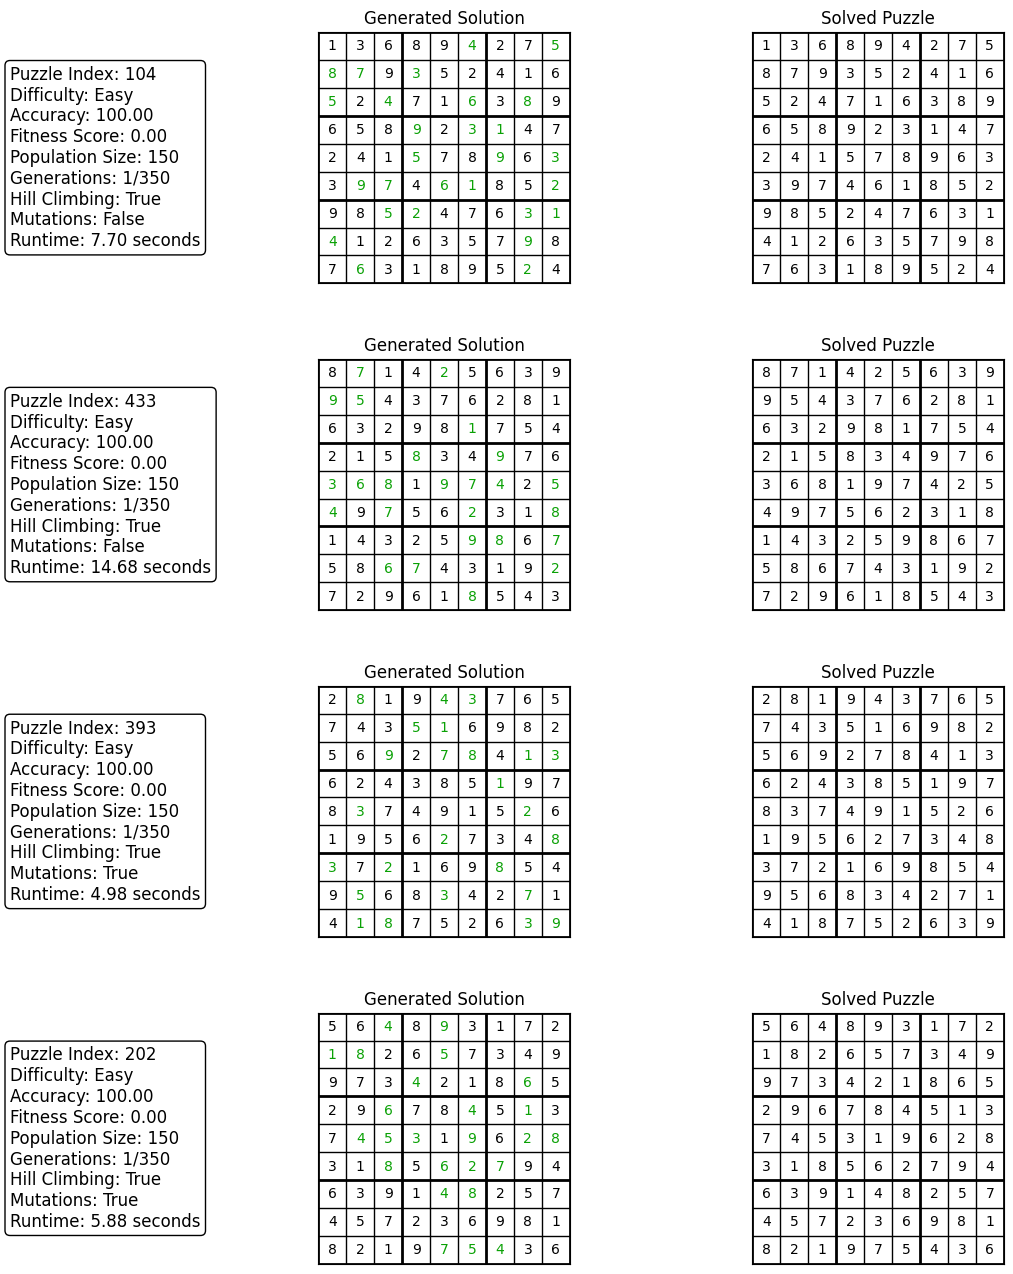

In [4]:
mutation_easy_results = compare_puzzles(selected_easy, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(mutation_easy_results, puzzles, solutions, fig_title="mutation_comparison_EASY")

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
2

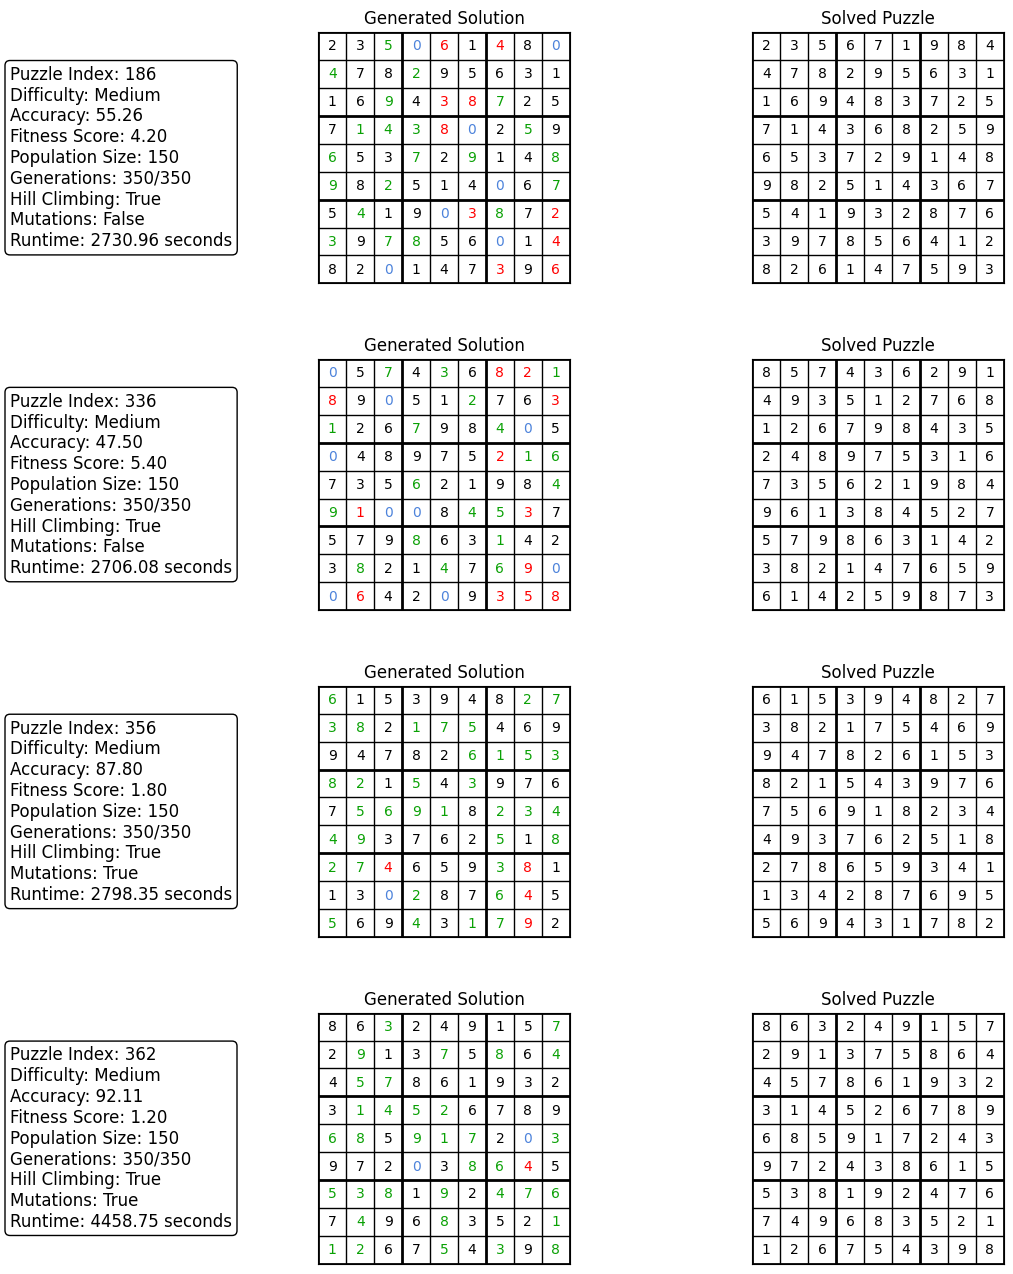

In [5]:
mutation_med_results = compare_puzzles(selected_medium, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(mutation_med_results, puzzles, solutions, fig_title="mutation_comparison_MEDIUM")

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
2

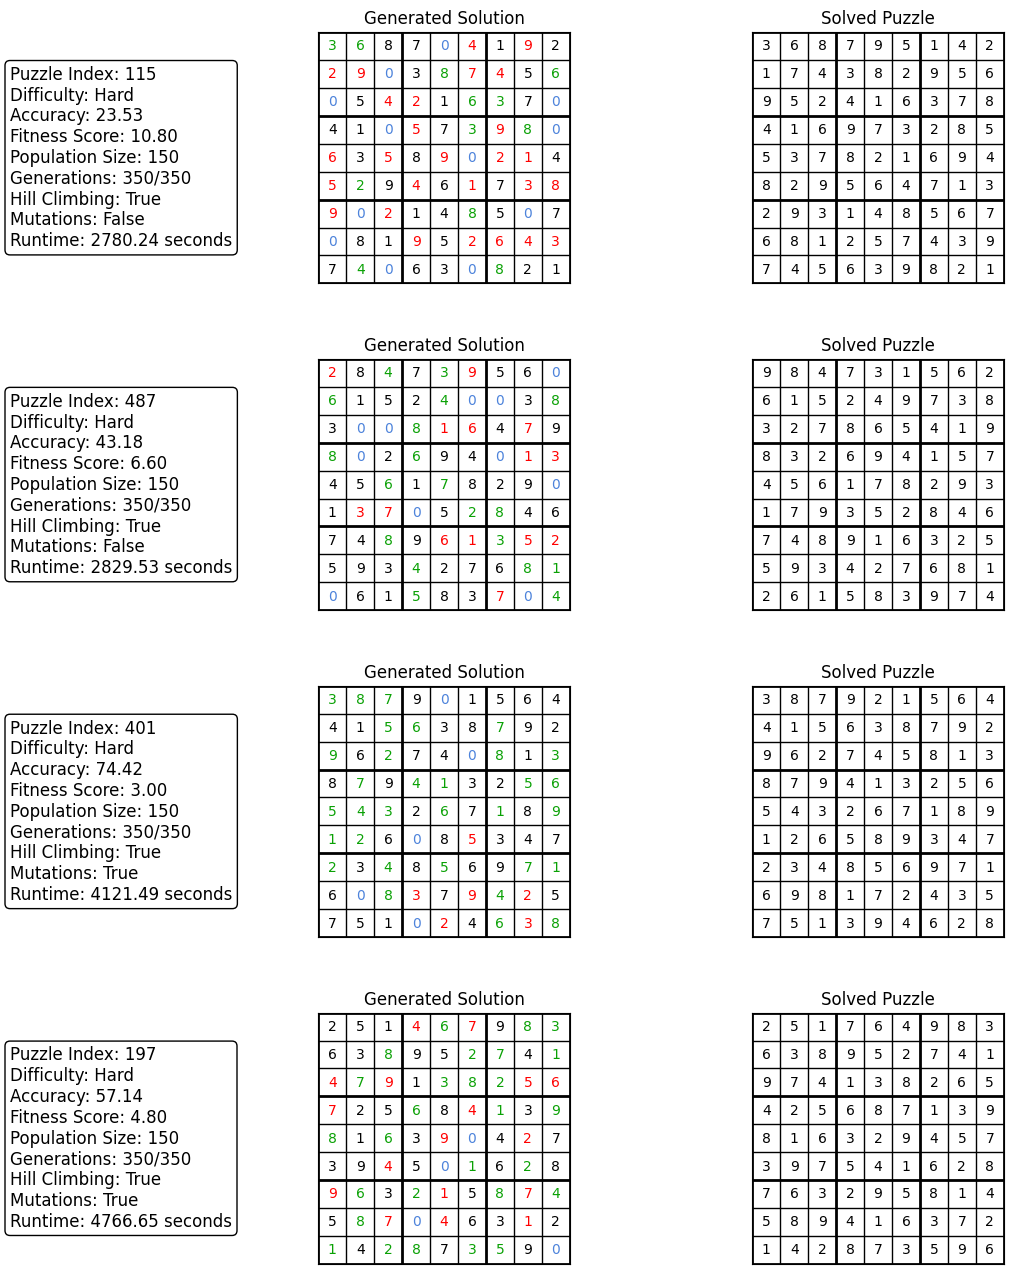

In [6]:
mutation_hard_results = compare_puzzles(selected_hard, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(mutation_hard_results, puzzles, solutions, fig_title="mutation_comparison_HARD")

In [7]:
# hill climbing vs no hill climbing
hills = [False, False, True, True]
mutate = [True, True, True, True]

# randomly choose 4 of each type
selected_easy = list(np.random.choice(easy_ind, size=4, replace=False))
selected_medium = list(np.random.choice(medium_ind, size=4, replace=False))
selected_hard = list(np.random.choice(hard_ind, size=4, replace=False))

0 350
0 350
0 350
0 350


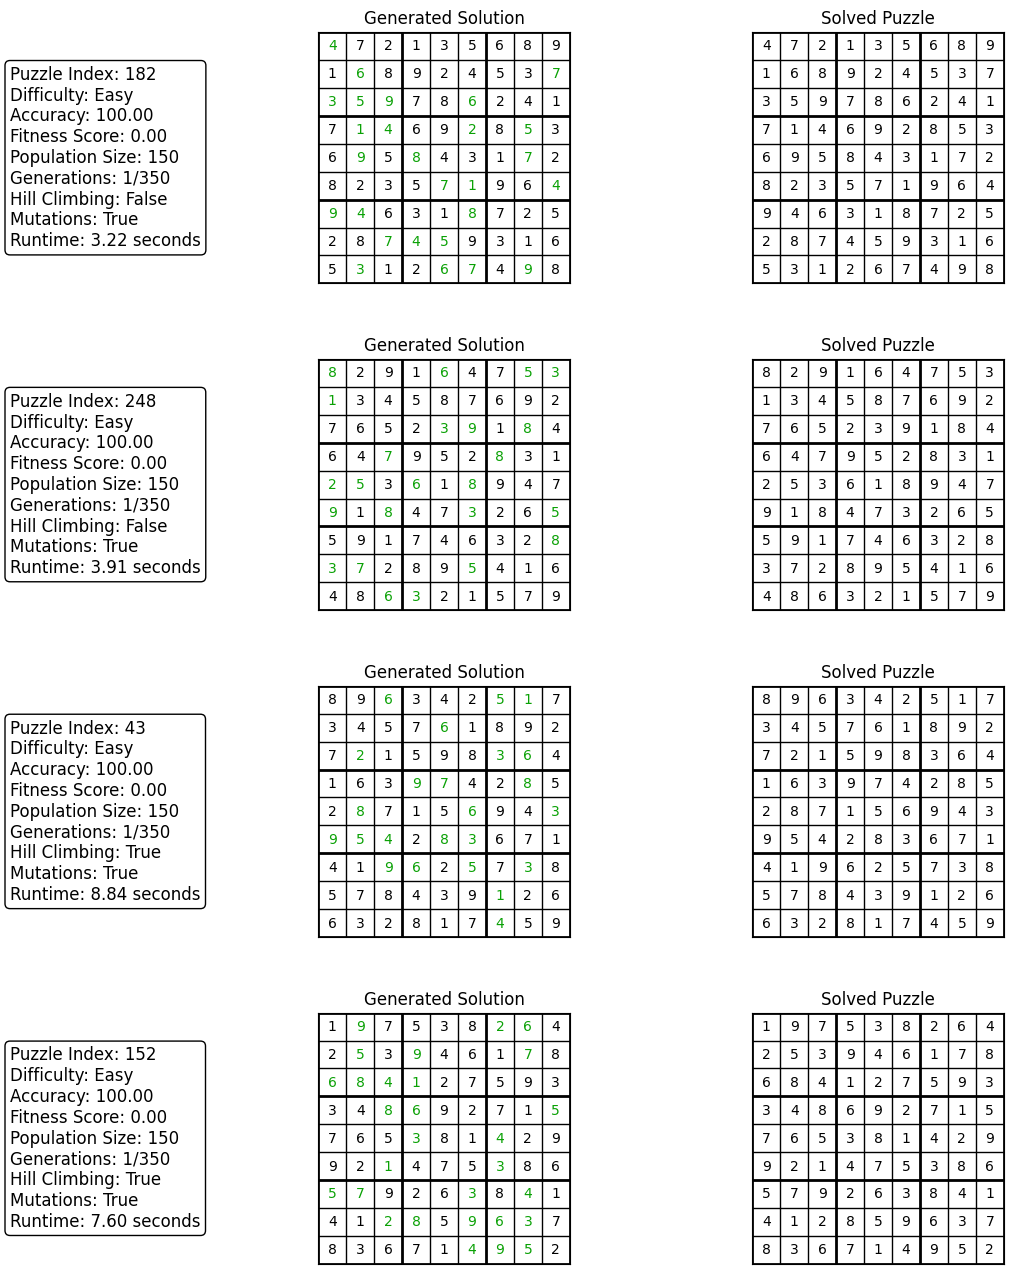

In [8]:
hill_easy_results = compare_puzzles(selected_easy, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(hill_easy_results, puzzles, solutions, fig_title="hill_comparison_EASY")

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
0 350
0 350


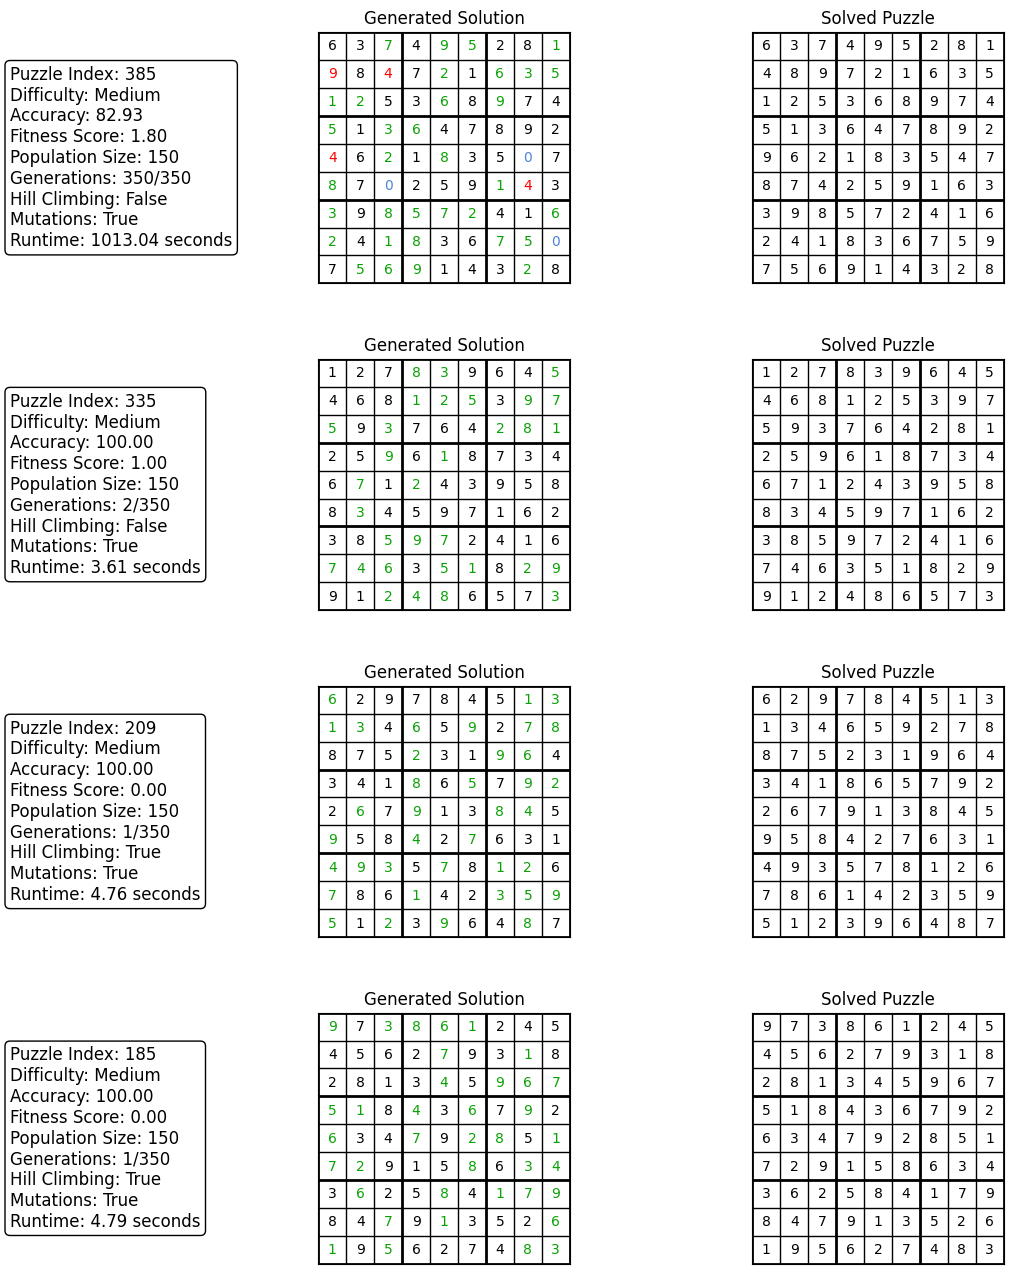

In [9]:
hill_med_results = compare_puzzles(selected_medium, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(hill_med_results, puzzles, solutions, fig_title="hill_comparison_MEDIUM")

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
2

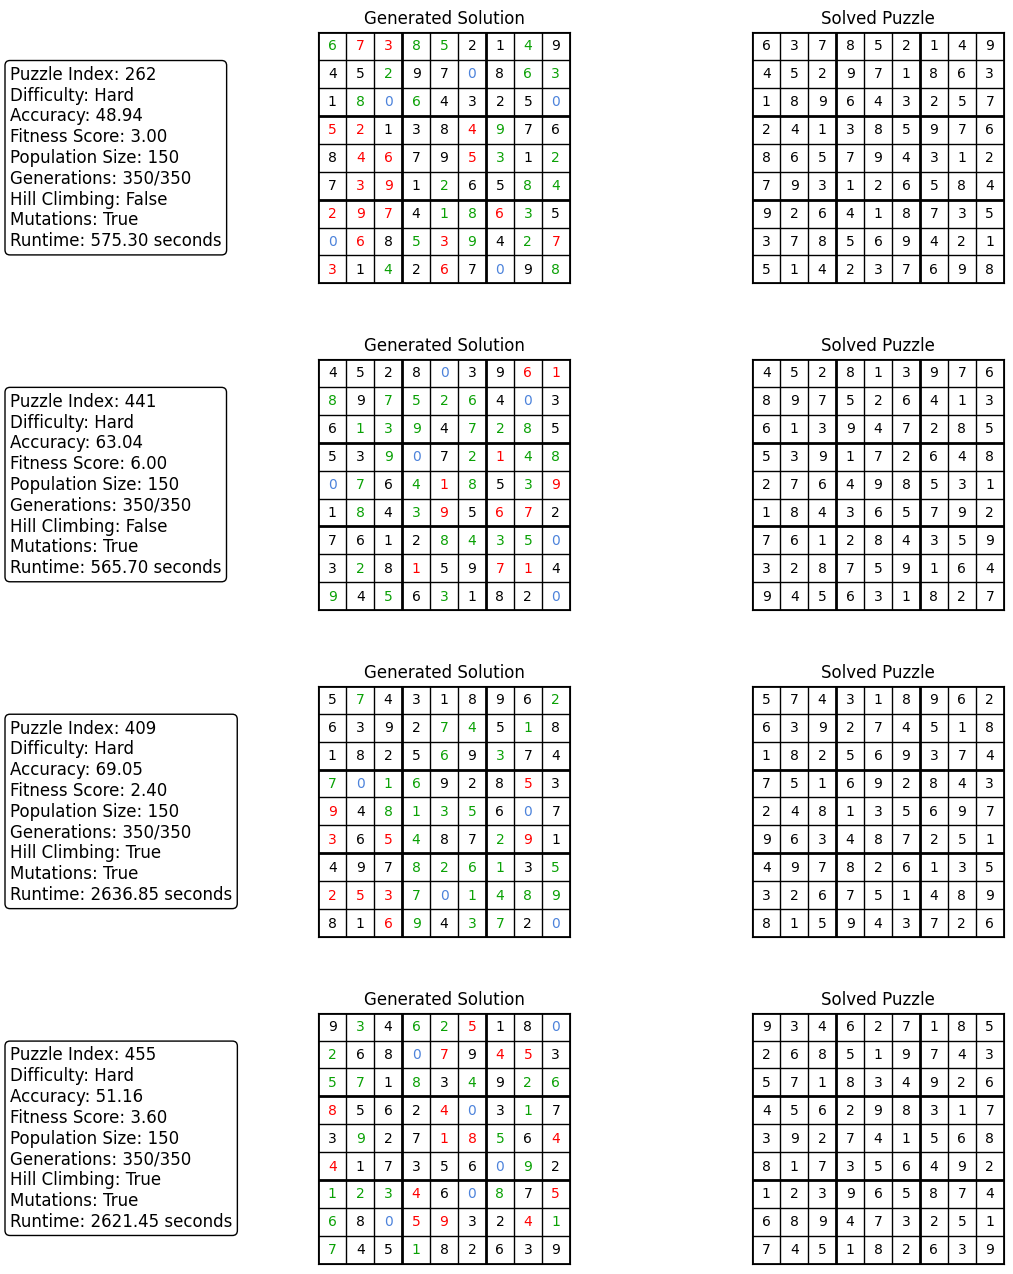

In [10]:
hill_hard_results = compare_puzzles(selected_hard, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(hill_hard_results, puzzles, solutions, fig_title="hill_comparison_HARD")

In [11]:
# same parameters, diff puzzles
mutate = [True, True, True]
hills = [True, True, True]
generations = [350, 350, 350]
pop_sizes = [150, 150, 150]

# randomly choose 3 of each type
selected_easy = list(np.random.choice(easy_ind, size=3, replace=False))
selected_medium = list(np.random.choice(medium_ind, size=3, replace=False))
selected_hard = list(np.random.choice(hard_ind, size=3, replace=False))

0 350
0 350
0 350


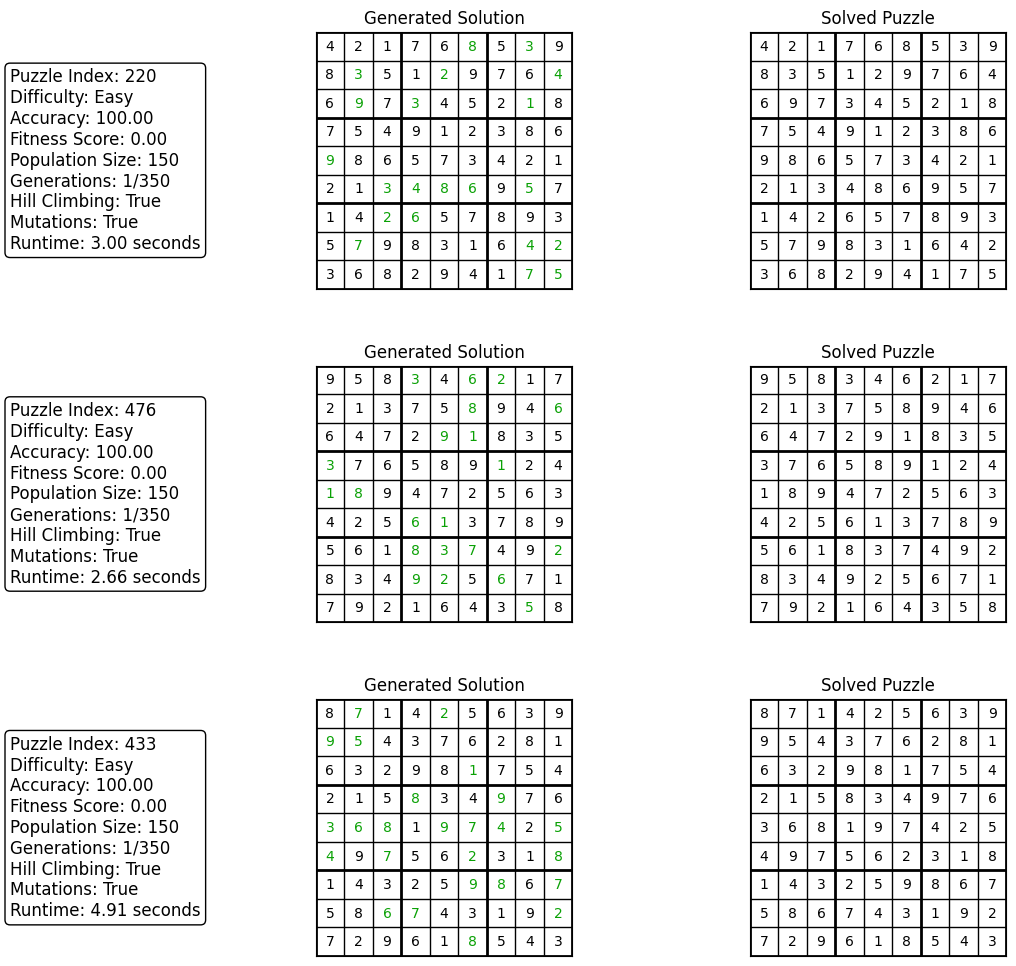

In [12]:
same_params_easy_results = compare_puzzles(selected_easy, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(same_params_easy_results, puzzles, solutions, fig_title="same_params_EASY")

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350


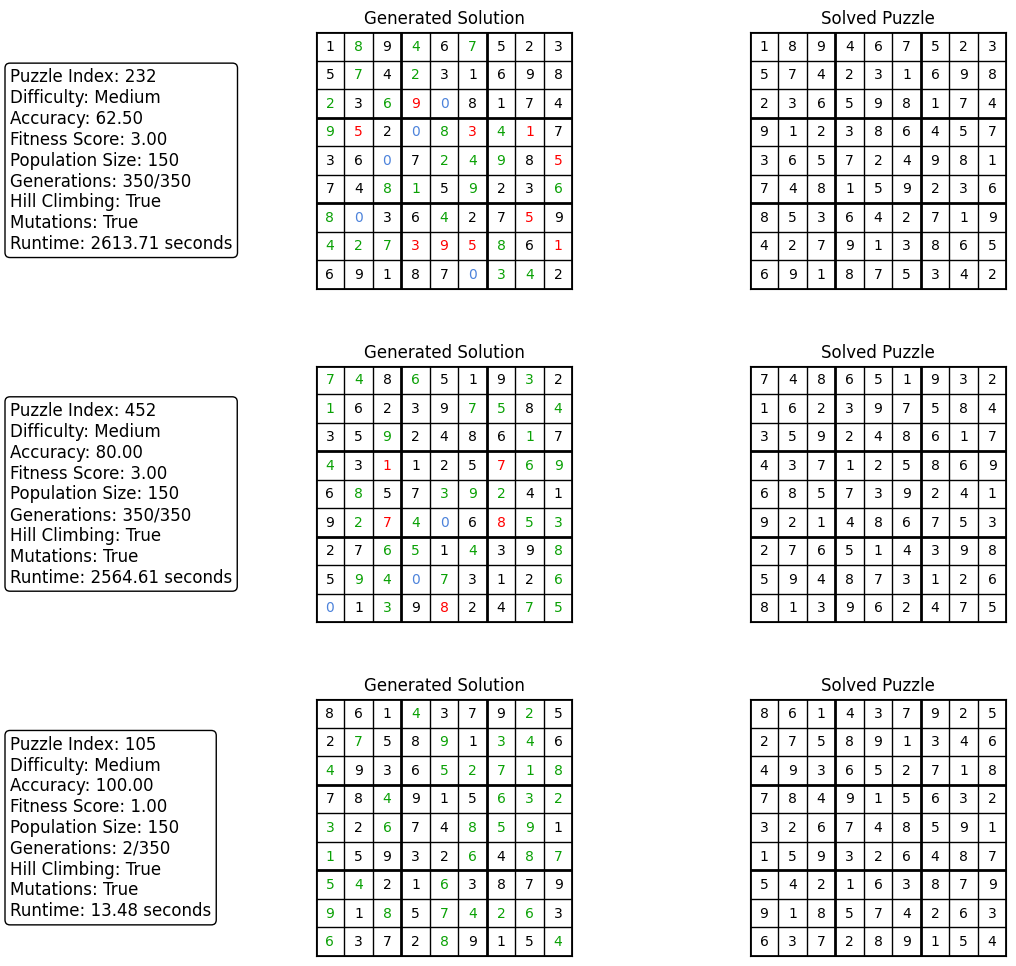

In [13]:
same_params_med_results = compare_puzzles(selected_medium, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(same_params_med_results, puzzles, solutions, fig_title="same_params_MEDIUM")

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350

0 350
10 350
20 350
30 350
40 350
50 350
60 350
70 350
80 350
90 350
100 350
110 350
120 350
130 350
140 350
150 350
160 350
170 350
180 350
190 350
200 350
210 350
220 350
230 350
240 350
250 350
260 350
270 350
280 350
290 350
300 350
310 350
320 350
330 350
340 350



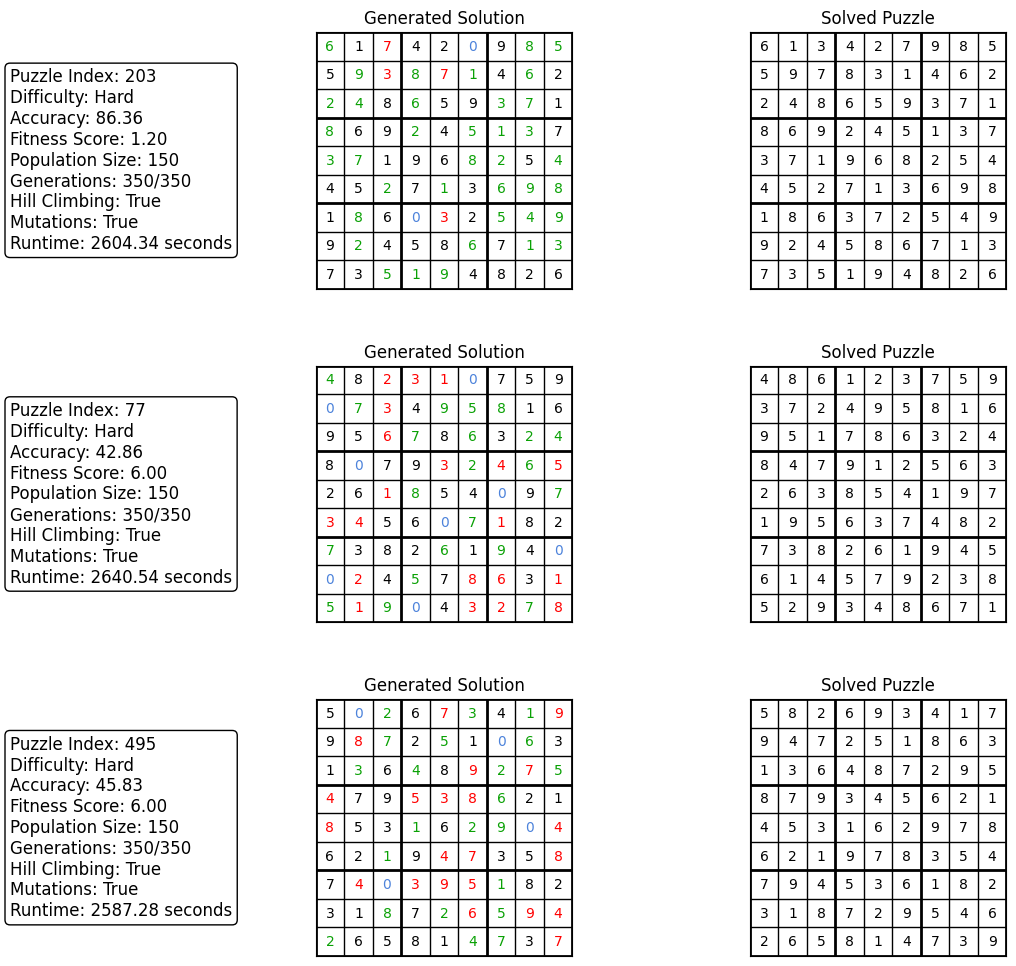

In [14]:
same_params_hard_results = compare_puzzles(selected_hard, puzzles, solutions, pop_sizes, generations, mutations=mutate, hills=hills)
plot_compare_puzzles(same_params_hard_results, puzzles, solutions, fig_title="same_params_HARD")